In [134]:
import pandas as pd
import numpy as np
import nltk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from matplotlib import rcParams
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
import seaborn as sns
import enchant
d = enchant.Dict("en_US")

In [2]:
df = pd.read_csv("Downloads/DataScientist.csv")

In [3]:
df = df.rename(columns = {"Salary Estimate": "Salary"})

In [4]:
for i in range(df.shape[0]):
    df.loc[i, 'Salary'] = df.loc[i, 'Salary'].replace(' (Glassdoor est.)', '')
    df.loc[i, 'Salary'] = df.loc[i, 'Salary'].replace('(Glassdoor est.)', '')
    df.loc[i, 'Salary'] = df.loc[i, 'Salary'].replace('(Employer est.)', '')
    df.loc[i, 'Salary'] = df.loc[i, 'Salary'].replace(' (Employer est.)', '')
    

In [5]:
df.head()

,Unnamed: 0,index,Job Title,Salary,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Senior Data Scientist,$111K-$181K,"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,1,1,"Data Scientist, Product Analytics",$111K-$181K,"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,2,2,Data Science Manager,$111K-$181K,Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,True
3,3,3,Data Analyst,$111K-$181K,Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
4,4,4,"Director, Data Science",$111K-$181K,"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1


In [6]:
df['min_salary'] = df['Salary']
df['max_salary'] = df['Salary']

In [7]:
from nltk.stem import RegexpStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words
from nltk.tokenize import WhitespaceTokenizer

In [8]:
salaries = df['Salary']
inds = []
for i in range(len(salaries)):
    if 'Per' in salaries[i]:
        inds.append(i)
df = df.drop(inds)
df = df.reset_index()

In [9]:
for i in range(df.shape[0]):
    salary = df['Salary'][i]
    ind = salary.index('-')
    min_salary = salary[0:ind]
    max_salary = salary[ind+1:len(salary)]
    df.loc[i,'min_salary'] = float(min_salary[1:len(min_salary)-1])
    df.loc[i,'max_salary'] = float(max_salary[1:len(max_salary)-1])

In [10]:
df = df.drop(columns=['index', 'Unnamed: 0', 'Size', 'Headquarters', 'Founded', 'Revenue', 'Type of ownership', 'Competitors','Industry', 'Salary', 'Rating', 'Easy Apply', 'level_0'])

In [11]:
df = df.rename(columns = {'Job Description': 'Text'})

In [12]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [13]:
prog_langs = ['SQL', 'R', 'OCaml', 'Python', 'SAS', 'PowerBI', 'Tableau', 'Java', 'Javascript' 'Excel', 'TensorFlow', 'Matlab', 'C++', 'AWS', 'NLP', 'Julia', 'C', 'Stata', 'Scala']
prog_langs = [lang.lower() for lang in prog_langs]

In [14]:
lemmatizer = WordNetLemmatizer()

In [15]:
texts = []
titles = []
descriptions = []
for i in range(df.shape[0]):
    words = tokenizer.tokenize(df.loc[i, 'Text'])
    jobs = tokenizer.tokenize(df.loc[i, 'Job Title'])
    tex = [lemmatizer.lemmatize(word.lower()) for word in words if not word.lower() in stopwords.words('english') and (d.check(word) or word in prog_langs)]
    descript = [des for des in tex if not des in prog_langs]
    j = [lemmatizer.lemmatize(job.lower()) for job in jobs if not job.lower() in stopwords.words('english') and d.check(job)]
    texts.append(tex)
    titles.append(j)
    descriptions.append(descript)

In [16]:
df['Text_red'] = pd.Series(texts)
df['Job_red'] = pd.Series(titles)
df['Describe'] = pd.Series(descriptions)

In [17]:
tk = WhitespaceTokenizer()
loc_sec = []
for i in range(df.shape[0]):
    loc_ind = df.loc[i, 'Location'].index(',')
    loc_str = (df.loc[i,'Location'][0:loc_ind]).replace(" ", "_") + df.loc[i,'Location'][loc_ind+1:] + ' '
    sec_str = (df.loc[i,'Sector']).replace('&', '')
    tot_list = tk.tokenize(loc_str + (sec_str.replace('  ','_')).replace(' ', '_'))
    loc_sec.append(tot_list)

df['loc_sec'] = pd.Series(loc_sec)  

In [18]:
df.head()

,Job Title,Text,Company Name,Location,Sector,min_salary,max_salary,Text_red,Job_red,Describe,loc_sec
0,Senior Data Scientist,"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",Hopper\n3.5,"New York, NY",Travel & Tourism,111.0,181.0,"[hopper, hopper, mission, make, booking, trave...","[senior, data, scientist]","[hopper, hopper, mission, make, booking, trave...","[New_York, NY, Travel_Tourism]"
1,"Data Scientist, Product Analytics","At Noom, we use scientifically proven methods ...",Noom US\n4.5,"New York, NY",Consumer Services,111.0,181.0,"[use, scientifically, proven, method, help, us...","[data, scientist, product]","[use, scientifically, proven, method, help, us...","[New_York, NY, Consumer_Services]"
2,Data Science Manager,Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,Decode_M,"New York, NY",-1,111.0,181.0,"[decode, decode, com, data, science, manager, ...","[data, science, manager]","[decode, decode, com, data, science, manager, ...","[New_York, NY, -1]"
3,Data Analyst,Sapphire Digital seeks a dynamic and driven mi...,Sapphire Digital\n3.4,"Lyndhurst, NJ",Information Technology,111.0,181.0,"[sapphire, digital, seek, dynamic, driven, mid...","[data, analyst]","[sapphire, digital, seek, dynamic, driven, mid...","[Lyndhurst, NJ, Information_Technology]"
4,"Director, Data Science","Director, Data Science - (200537)\nDescription...",United Entertainment Group\n3.4,"New York, NY",Business Services,111.0,181.0,"[director, data, science, description, intelli...","[director, data, science]","[director, data, science, description, intelli...","[New_York, NY, Business_Services]"


In [19]:
Languages = []
for i in range(df.shape[0]):
    langs = [lang for lang in prog_langs if lang in df.loc[i, 'Text_red']]
    Languages.append(langs)

In [20]:
df['Prog_Languages'] = pd.Series(Languages)

In [21]:
avg_sal = []
for i in range(df.shape[0]):
    avg = (df.loc[i, 'min_salary'] + df.loc[i, 'max_salary'])/2
    avg_sal.append(avg)

In [22]:
df['avg_salaries'] = pd.Series(avg_sal)

In [23]:
indices = []
for i in range(len(df.Prog_Languages)):
    if len(df.Prog_Languages[i]) == 0:
        indices.append(i)

In [24]:
indices = []
for i in range(len(df.Prog_Languages)):
    if 'aws' in df.Prog_Languages[i]:
        indices.append(i)

In [25]:
df.head()

,Job Title,Text,Company Name,Location,Sector,min_salary,max_salary,Text_red,Job_red,Describe,loc_sec,Prog_Languages,avg_salaries
0,Senior Data Scientist,"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",Hopper\n3.5,"New York, NY",Travel & Tourism,111.0,181.0,"[hopper, hopper, mission, make, booking, trave...","[senior, data, scientist]","[hopper, hopper, mission, make, booking, trave...","[New_York, NY, Travel_Tourism]","[sql, r, tableau]",146.0
1,"Data Scientist, Product Analytics","At Noom, we use scientifically proven methods ...",Noom US\n4.5,"New York, NY",Consumer Services,111.0,181.0,"[use, scientifically, proven, method, help, us...","[data, scientist, product]","[use, scientifically, proven, method, help, us...","[New_York, NY, Consumer_Services]","[sql, python]",146.0
2,Data Science Manager,Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,Decode_M,"New York, NY",-1,111.0,181.0,"[decode, decode, com, data, science, manager, ...","[data, science, manager]","[decode, decode, com, data, science, manager, ...","[New_York, NY, -1]","[r, python]",146.0
3,Data Analyst,Sapphire Digital seeks a dynamic and driven mi...,Sapphire Digital\n3.4,"Lyndhurst, NJ",Information Technology,111.0,181.0,"[sapphire, digital, seek, dynamic, driven, mid...","[data, analyst]","[sapphire, digital, seek, dynamic, driven, mid...","[Lyndhurst, NJ, Information_Technology]","[sql, r, python]",146.0
4,"Director, Data Science","Director, Data Science - (200537)\nDescription...",United Entertainment Group\n3.4,"New York, NY",Business Services,111.0,181.0,"[director, data, science, description, intelli...","[director, data, science]","[director, data, science, description, intelli...","[New_York, NY, Business_Services]","[r, python]",146.0


In [26]:
np.sort(df.avg_salaries.unique())

array([ 43.5,  48.5,  53. ,  53.5,  54. ,  55. ,  56. ,  56.5,  57.5,
        59.5,  60. ,  61.5,  62. ,  62.5,  63. ,  63.5,  64. ,  64.5,
        65. ,  65.5,  68.5,  70.5,  71. ,  71.5,  73. ,  75. ,  75.5,
        76.5,  77.5,  78. ,  78.5,  80. ,  80.5,  82.5,  83.5,  84. ,
        84.5,  85.5,  86. ,  87. ,  87.5,  92. ,  92.5,  94. ,  94.5,
        96.5,  98. ,  99. ,  99.5, 100.5, 101.5, 104. , 104.5, 105.5,
       106.5, 107. , 107.5, 109. , 111.5, 112. , 114. , 116. , 118. ,
       118.5, 120. , 121. , 122. , 122.5, 124. , 124.5, 125. , 125.5,
       126. , 128. , 129. , 130. , 131.5, 132. , 132.5, 133. , 134. ,
       136. , 136.5, 139.5, 140.5, 143. , 145. , 146. , 146.5, 148.5,
       149.5, 150. , 152. , 153.5, 156.5, 159.5, 160.5, 161. , 161.5,
       162.5, 169.5, 170. , 172. , 174.5, 176. , 177.5, 183. , 190. ,
       193.5, 205. , 225. ])

In [27]:
df = df.drop(columns = ['min_salary', 'max_salary'])

In [28]:
df.head()

,Job Title,Text,Company Name,Location,Sector,Text_red,Job_red,Describe,loc_sec,Prog_Languages,avg_salaries
0,Senior Data Scientist,"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",Hopper\n3.5,"New York, NY",Travel & Tourism,"[hopper, hopper, mission, make, booking, trave...","[senior, data, scientist]","[hopper, hopper, mission, make, booking, trave...","[New_York, NY, Travel_Tourism]","[sql, r, tableau]",146.0
1,"Data Scientist, Product Analytics","At Noom, we use scientifically proven methods ...",Noom US\n4.5,"New York, NY",Consumer Services,"[use, scientifically, proven, method, help, us...","[data, scientist, product]","[use, scientifically, proven, method, help, us...","[New_York, NY, Consumer_Services]","[sql, python]",146.0
2,Data Science Manager,Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,Decode_M,"New York, NY",-1,"[decode, decode, com, data, science, manager, ...","[data, science, manager]","[decode, decode, com, data, science, manager, ...","[New_York, NY, -1]","[r, python]",146.0
3,Data Analyst,Sapphire Digital seeks a dynamic and driven mi...,Sapphire Digital\n3.4,"Lyndhurst, NJ",Information Technology,"[sapphire, digital, seek, dynamic, driven, mid...","[data, analyst]","[sapphire, digital, seek, dynamic, driven, mid...","[Lyndhurst, NJ, Information_Technology]","[sql, r, python]",146.0
4,"Director, Data Science","Director, Data Science - (200537)\nDescription...",United Entertainment Group\n3.4,"New York, NY",Business Services,"[director, data, science, description, intelli...","[director, data, science]","[director, data, science, description, intelli...","[New_York, NY, Business_Services]","[r, python]",146.0


In [29]:
lemmatizer = WordNetLemmatizer()

In [30]:
salary_classes = []

for i in range(df.shape[0]):
    if df.loc[i,'avg_salaries'] > 164:
        salary_classes.append(2)
    elif df.loc[i,'avg_salaries'] > 103:
         salary_classes.append(1)
    else:
        salary_classes.append(0)
    
df['salary_classes'] = pd.Series(salary_classes)

In [31]:
indices = []
for i in range(df.shape[0]):
    if len(df.loc[i,'Prog_Languages']) > 0:
        indices.append(i)

df_lang = df.iloc[indices]

In [32]:
lit = []
for i in range(df.shape[0]):
    lit.append(" ".join(df.Prog_Languages[i]))

In [33]:
indices = []
indys = []
for i in range(df.shape[0]):
    if 'data' in df.loc[i,'Job_red']:
        indices.append(i)
    else: 
        indys.append(i)

In [34]:
df.iloc[indices].head()

,Job Title,Text,Company Name,Location,Sector,Text_red,Job_red,Describe,loc_sec,Prog_Languages,avg_salaries,salary_classes
0,Senior Data Scientist,"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",Hopper\n3.5,"New York, NY",Travel & Tourism,"[hopper, hopper, mission, make, booking, trave...","[senior, data, scientist]","[hopper, hopper, mission, make, booking, trave...","[New_York, NY, Travel_Tourism]","[sql, r, tableau]",146.0,1
1,"Data Scientist, Product Analytics","At Noom, we use scientifically proven methods ...",Noom US\n4.5,"New York, NY",Consumer Services,"[use, scientifically, proven, method, help, us...","[data, scientist, product]","[use, scientifically, proven, method, help, us...","[New_York, NY, Consumer_Services]","[sql, python]",146.0,1
2,Data Science Manager,Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,Decode_M,"New York, NY",-1,"[decode, decode, com, data, science, manager, ...","[data, science, manager]","[decode, decode, com, data, science, manager, ...","[New_York, NY, -1]","[r, python]",146.0,1
3,Data Analyst,Sapphire Digital seeks a dynamic and driven mi...,Sapphire Digital\n3.4,"Lyndhurst, NJ",Information Technology,"[sapphire, digital, seek, dynamic, driven, mid...","[data, analyst]","[sapphire, digital, seek, dynamic, driven, mid...","[Lyndhurst, NJ, Information_Technology]","[sql, r, python]",146.0,1
4,"Director, Data Science","Director, Data Science - (200537)\nDescription...",United Entertainment Group\n3.4,"New York, NY",Business Services,"[director, data, science, description, intelli...","[director, data, science]","[director, data, science, description, intelli...","[New_York, NY, Business_Services]","[r, python]",146.0,1


In [35]:
roles = df['Job_red']

In [36]:
title_list = []
for i in range(len(roles)):
    for j in range(len(roles[i])):
        if 'sr' in roles[i][j]:
            title_list.append('senior')
        else:
            title_list.append(lemmatizer.lemmatize(roles[i][j]))
    

In [37]:
title_list = pd.Series(title_list)

In [38]:
title_counts = title_list.value_counts()
ind = 0
for i in range(len(title_counts)):
    if title_counts[i] < 4:
        ind = i
        break
        

In [39]:
top_titles = title_counts[0:19].index

In [40]:
salary_title = []
for i in range(len(top_titles)):
    summ = 0
    count = 0
    for j in range(df.shape[0]):
        if top_titles[i] in df.loc[j, 'Job_red']:
            summ = summ + df.loc[j, 'avg_salaries']
            count = count + 1
    mean = summ/count
    salary_title.append(mean)
        

In [41]:
salaries_df = pd.Series(index = top_titles, data = salary_title)
salaries_df.sort_values(ascending=False)

learning        123.777174
machine         123.438202
principal       117.392000
scientist       115.603666
lead            112.089286
senior          111.893319
manager         110.930000
data            109.908396
science         109.549261
associate       106.500000
research        106.250000
engineer        104.348910
ii              102.425676
analyst         101.415636
business        100.935252
quantitative     96.895062
big              96.210317
consultant       95.174699
intelligence     94.608247
dtype: float64

In [42]:
pro_langs = df['Prog_Languages']
prog_list = []
for i in range(len(pro_langs)):
    for j in range(len(pro_langs[i])):
        prog_list.append(pro_langs[i][j])
        
prog_list = pd.Series(prog_list)
prog_counts = prog_list.value_counts()
ind = 0
for i in range(len(prog_counts)):
    if prog_counts[i] < 1:
        ind = i
        break

In [43]:
top_prog = prog_counts[0:15].index

In [44]:
prog_title = []
for i in range(len(top_prog)):
    summ = 0
    count = 0
    for j in range(df.shape[0]):
        if top_prog[i] in df.loc[j, 'Prog_Languages']:
            summ = summ + df.loc[j, 'avg_salaries']
            count = count + 1
    mean = summ/count
    prog_title.append(mean)

In [45]:
progs_df = pd.Series(index = top_prog, data = prog_title)
progs_df.sort_values(ascending=False)

stata         152.000000
julia         122.500000
tensorflow    120.636364
r             114.162917
python        113.032911
c             111.337176
scala         111.044289
java          110.191349
sql           109.873083
tableau       106.985821
nlp            99.000000
aws            81.666667
sas            63.500000
dtype: float64

In [46]:
program = pd.DataFrame()

for prog in progs_df.index:
    indices = []
    for i in range(df.shape[0]):
        if prog in df.loc[i,'Prog_Languages']:
            indices.append(i)
    program[prog] = df.iloc[indices].avg_salaries

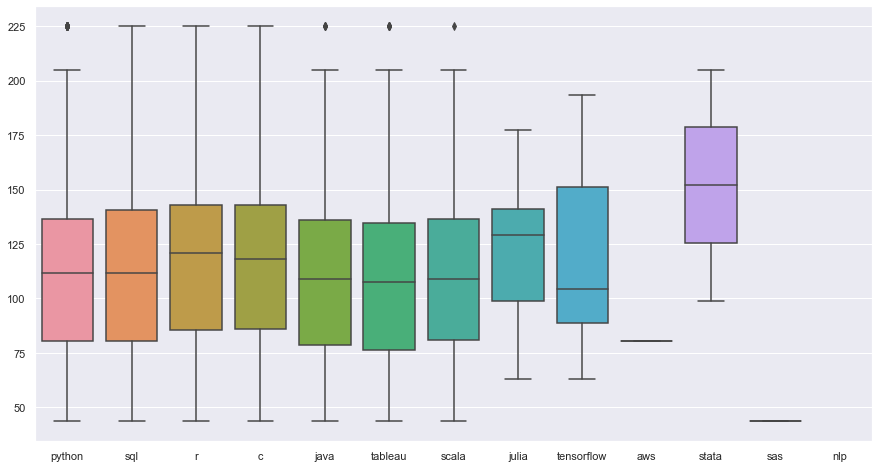

In [47]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.boxplot(data=program)

In [48]:
title_df = pd.DataFrame()

for titl in salaries_df.index:
    indices = []
    for i in range(df.shape[0]):
        if titl in df.loc[i,'Job_red']:
            indices.append(i)
    title_df[titl] = df.iloc[indices].avg_salaries

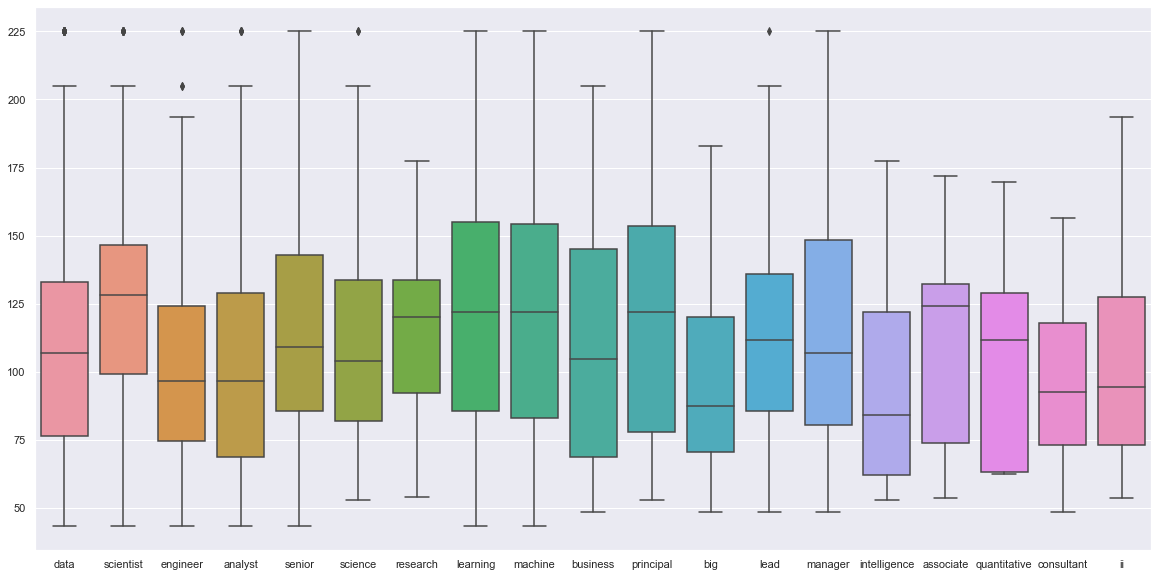

In [49]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.boxplot(data=title_df)

In [50]:
new_prog_df = pd.DataFrame(index = range(df.shape[0]),columns = progs_df.index).fillna(0)

for i in range(df.shape[0]):
    for prog in df.loc[i, 'Prog_Languages']:
        if prog in new_prog_df.columns:
            new_prog_df.loc[i, prog] = new_prog_df.loc[i, prog] + 1
        

In [51]:
new_prog_df['avg_salaries'] = df['avg_salaries']
new_prog_df['salary_label'] = df['salary_classes']

In [52]:
for i in range(new_prog_df.shape[0]):
    if new_prog_df.loc[i,'avg_salaries'] > 105:
        new_prog_df.loc[i,'salary_label'] = 1
    else:
        new_prog_df.loc[i,'salary_label'] = 0

In [53]:
X = new_prog_df.drop(columns = ['avg_salaries', 'salary_label'])
y = new_prog_df['salary_label']

In [54]:
new_title_df = pd.DataFrame(index = range(df.shape[0]),columns = title_df.columns).fillna(0)

for i in range(df.shape[0]):
    for t in df.loc[i, 'Job_red']:
        if t in new_title_df.columns:
            new_title_df.loc[i, t] = new_title_df.loc[i, t] + 1

In [55]:
new_title_df['avg_salaries'] = df['avg_salaries']
new_title_df['salary_label'] = df['salary_classes']

In [56]:
for i in range(new_title_df.shape[0]):
    if new_title_df.loc[i,'avg_salaries'] > 105:
        new_title_df.loc[i,'salary_label'] = 1
    else:
        new_title_df.loc[i,'salary_label'] = 0

In [57]:
X = new_title_df.drop(columns = ['avg_salaries', 'salary_label'])
X = X.loc[:,'data':'machine']
y = new_title_df['salary_label']

In [94]:
def get_score(model, X_train, X_test, Y_train, Y_test):
    model.fit(X_train,Y_train)
    return model.score(X_test, Y_test)

<font size="6">Programming Languages</font>

In [95]:
cross_vals = []
vectorizer = TfidfVectorizer()
txt_list = [" ".join(txt) for txt in df['Prog_Languages']]
Y = new_prog_df['salary_label']


X_train, X_test, Y_train, Y_test = train_test_split(txt_list, Y, stratify=Y, test_size= 0.3, shuffle=True, random_state=42)

vectors = vectorizer.fit_transform(X_train)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_train = pd.DataFrame(denselist, columns=feature_names)

vectors = vectorizer.transform(X_test)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_test = pd.DataFrame(denselist, columns=feature_names)

df_train['salary_label']  = Y_train.reset_index(drop=True)
df_test['salary_label'] = Y_test.reset_index(drop=True)

x_train = df_train.drop(columns = ['salary_label'])
y_train = df_train['salary_label']

x_test = df_test.drop(columns = ['salary_label'])
y_test = df_test['salary_label']

cross_vals.append(cross_val_score(LogisticRegression(),vectorizer.transform(txt_list), Y, cv=3))
cross_vals.append(cross_val_score(svm.SVC(),vectorizer.transform(txt_list), Y, cv=3))


C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [96]:
cross_vals

[array([0.57407407, 0.51774691, 0.55246914]),
 array([0.57407407, 0.51466049, 0.59722222])]

<AxesSubplot:>

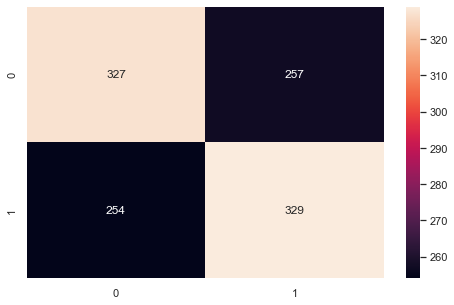

In [97]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [98]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.5621251071122536

<AxesSubplot:>

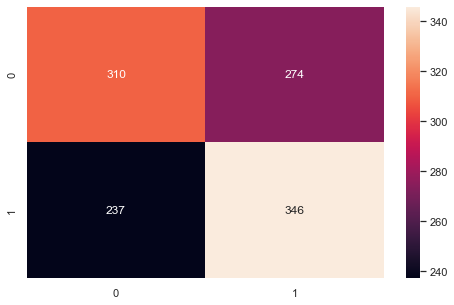

In [99]:
clf = svm.SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [100]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.5621251071122536

<AxesSubplot:>

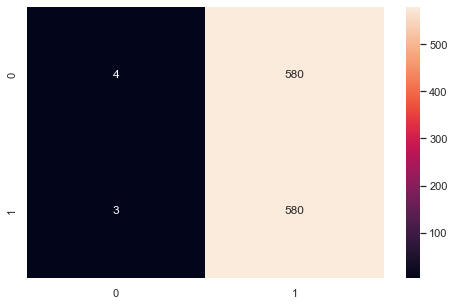

In [101]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [102]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.5004284490145673

C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

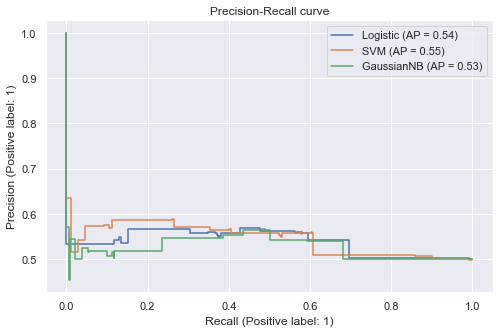

In [103]:
plot_precision_recall_curve(log_reg, x_test, y_test, ax = plt.gca(),name = "Logistic")

plot_precision_recall_curve(clf, x_test, y_test, ax = plt.gca(),name = "SVM")

plot_precision_recall_curve(gnb, x_test, y_test, ax = plt.gca(),name = "GaussianNB")

plt.title('Precision-Recall curve')
plt.legend(loc='upper right')

<font size="6">Job Titles</font>

In [104]:
cross_vals = []
vectorizer = TfidfVectorizer()
job_title = [" ".join(txt) for txt in df['Job_red']]
Y = new_prog_df['salary_label']

X_train, X_test, Y_train, Y_test = train_test_split(job_title, Y, stratify=Y, test_size= 0.3, shuffle=True, random_state=42)

vectors = vectorizer.fit_transform(X_train)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_train = pd.DataFrame(denselist, columns=feature_names)

vectors = vectorizer.transform(X_test)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_test = pd.DataFrame(denselist, columns=feature_names)

df_train['salary_label']  = Y_train.reset_index(drop=True)
df_test['salary_label'] = Y_test.reset_index(drop=True)

x_train = df_train.drop(columns = ['salary_label'])
y_train = df_train['salary_label']

x_test = df_test.drop(columns = ['salary_label'])
y_test = df_test['salary_label']

cross_vals.append(cross_val_score(LogisticRegression(),vectorizer.transform(job_title), Y, cv=3))
cross_vals.append(cross_val_score(svm.SVC(),vectorizer.transform(job_title), Y, cv=3))

C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [105]:
cross_vals

[array([0.58256173, 0.51234568, 0.56018519]),
 array([0.57638889, 0.50617284, 0.57021605])]

<AxesSubplot:>

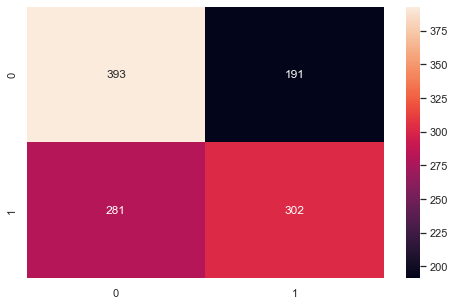

In [106]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [107]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.5955441302485004

<AxesSubplot:>

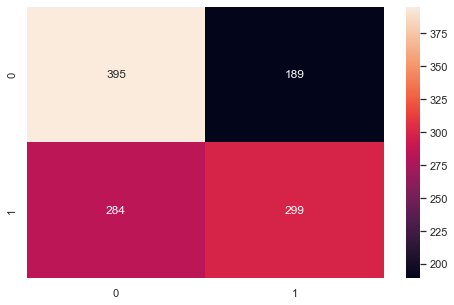

In [108]:
clf = svm.SVC(probability=True)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [109]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.5946872322193659

<AxesSubplot:>

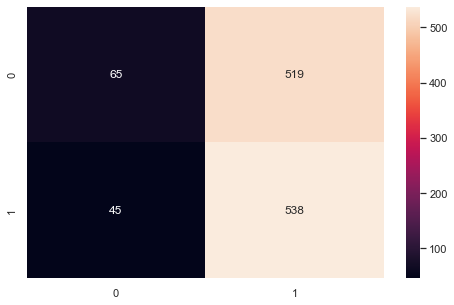

In [110]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [111]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.5167095115681234

C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

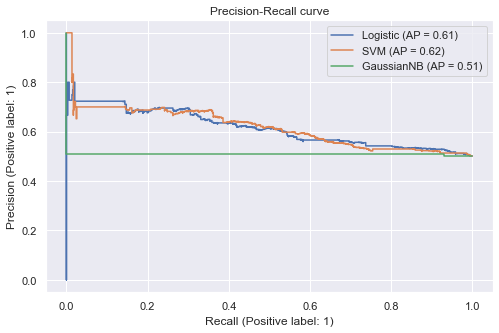

In [112]:
plot_precision_recall_curve(log_reg, x_test, y_test, ax = plt.gca(),name = "Logistic")

plot_precision_recall_curve(clf, x_test, y_test, ax = plt.gca(),name = "SVM")

plot_precision_recall_curve(gnb, x_test, y_test, ax = plt.gca(),name = "GaussianNB")

plt.title('Precision-Recall curve')
plt.legend(loc='upper right')

<font size="6">Overall Text</font>

In [135]:
cross_vals = []
vectorizer = TfidfVectorizer()
texts = [" ".join(txt) for txt in df['Text_red']]
Y = new_prog_df['salary_label']

X_train, X_test, Y_train, Y_test = train_test_split(texts, Y, stratify=Y, test_size= 0.3, shuffle=True, random_state=42)

vectors = vectorizer.fit_transform(X_train)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_train = pd.DataFrame(denselist, columns=feature_names)

vectors = vectorizer.transform(X_test)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_test = pd.DataFrame(denselist, columns=feature_names)

df_train['salary_label']  = Y_train.reset_index(drop=True)
df_test['salary_label'] = Y_test.reset_index(drop=True)

x_train = df_train.drop(columns = ['salary_label'])
y_train = df_train['salary_label']

x_test = df_test.drop(columns = ['salary_label'])
y_test = df_test['salary_label']

cross_vals.append(cross_val_score(LogisticRegression(),vectorizer.transform(texts), Y, cv=3))
cross_vals.append(cross_val_score(svm.SVC(),vectorizer.transform(texts), Y, cv=3))

C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [114]:
cross_vals

[array([0.57947531, 0.51774691, 0.61651235]),
 array([0.57561728, 0.51388889, 0.62885802])]

<AxesSubplot:>

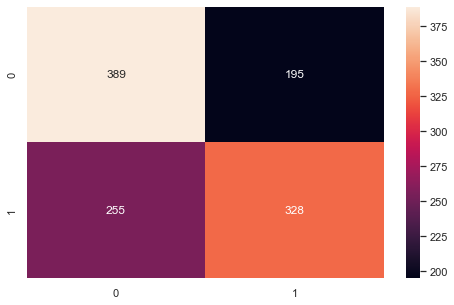

In [115]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [116]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.6143958868894601

<AxesSubplot:>

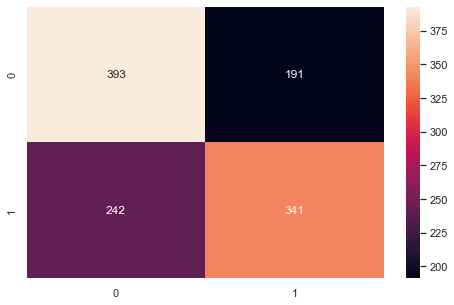

In [117]:
clf = svm.SVC(probability=True)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [118]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.6289631533847472

<AxesSubplot:>

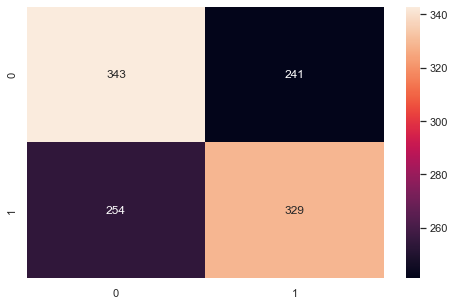

In [119]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [120]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.5758354755784062

C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

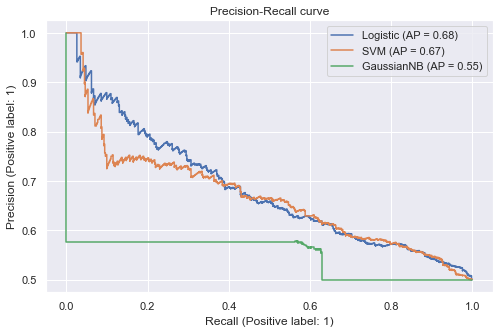

In [121]:
plot_precision_recall_curve(log_reg, x_test, y_test, ax = plt.gca(),name = "Logistic")

plot_precision_recall_curve(clf, x_test, y_test, ax = plt.gca(),name = "SVM")

plot_precision_recall_curve(gnb, x_test, y_test, ax = plt.gca(),name = "GaussianNB")

plt.title('Precision-Recall curve')
plt.legend(loc='upper right')

<font size="6">Location and Sector</font>

In [122]:
vectorizer = TfidfVectorizer()
texts = [" ".join(txt) for txt in df['loc_sec']]
Y = new_prog_df['salary_label']

X_train, X_test, Y_train, Y_test = train_test_split(texts, Y, stratify=Y, test_size= 0.3, shuffle=True, random_state=42)

vectors = vectorizer.fit_transform(X_train)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_train = pd.DataFrame(denselist, columns=feature_names)

vectors = vectorizer.transform(X_test)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_test = pd.DataFrame(denselist, columns=feature_names)

df_train['salary_label']  = Y_train.reset_index(drop=True)
df_test['salary_label'] = Y_test.reset_index(drop=True)

x_train = df_train.drop(columns = ['salary_label'])
y_train = df_train['salary_label']

x_test = df_test.drop(columns = ['salary_label'])
y_test = df_test['salary_label']


C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:>

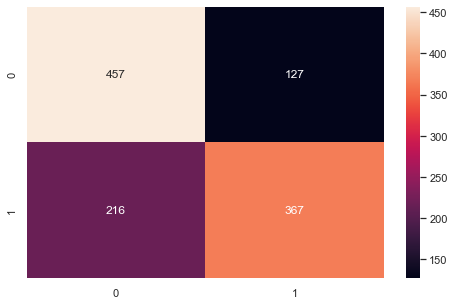

In [123]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [124]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.7060839760068551

<AxesSubplot:>

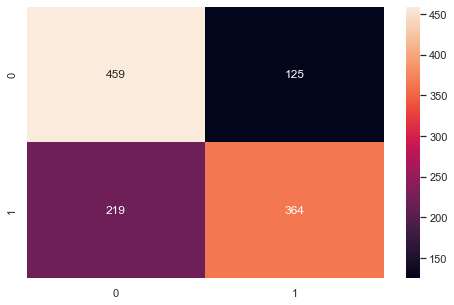

In [125]:
clf = svm.SVC(probability=True)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [126]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.7052270779777207

<AxesSubplot:>

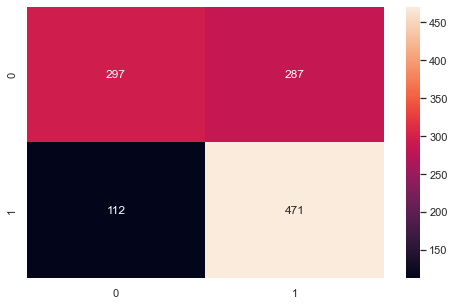

In [127]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
rcParams['figure.figsize'] = 8,5
sns.heatmap(cm,annot=True,fmt='g')

In [128]:
(cm[0][0] + cm[1][1])/len(y_pred)

0.6580976863753213

C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Keyon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

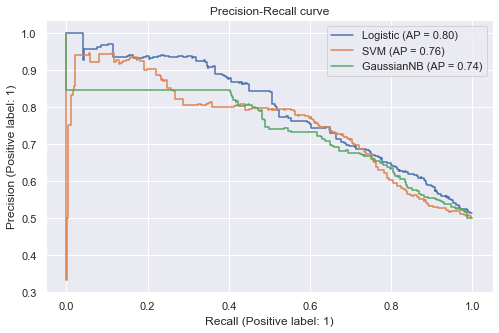

In [129]:
plot_precision_recall_curve(log_reg, x_test, y_test, ax = plt.gca(),name = "Logistic")

plot_precision_recall_curve(clf, x_test, y_test, ax = plt.gca(),name = "SVM")

plot_precision_recall_curve(gnb, x_test, y_test, ax = plt.gca(),name = "GaussianNB")

plt.title('Precision-Recall curve')
plt.legend(loc='upper right')
